In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display

# Path to csv file
folder = "/home/VRberry/Public/VR_core/calib_log/"
file_name = "calib_"
file_id = "1732"

csv_path = f"{folder}{file_name}{file_id}.csv"

df = pd.read_csv(csv_path)


In [37]:
# Ensure consistent ordering of marker types if you want
MARKER_TYPE_ORDER = ["REF", "DIST", "ANG"]

groups = []  # list of dicts: {"marker_type", "marker_id", "df_LR"}

for mtype in MARKER_TYPE_ORDER:
    df_mtype = df[df["marker_type"] == mtype]
    if df_mtype.empty:
        continue

    for mid in sorted(df_mtype["marker_id"].unique()):
        df_mid = df_mtype[df_mtype["marker_id"] == mid]

        # We want both eyes in the group
        if not {"L", "R"}.issubset(df_mid["eye"].unique()):
            continue

        # Split per eye and align by sample_index
        df_left = df_mid[df_mid["eye"] == "L"].sort_values("sample_index")
        df_right = df_mid[df_mid["eye"] == "R"].sort_values("sample_index")

        merged = pd.merge(
            df_left[["sample_index", "dx", "dy"]],
            df_right[["sample_index", "dx", "dy"]],
            on="sample_index",
            suffixes=("_L", "_R"),
            how="inner",
        )

        if merged.empty:
            continue

        groups.append(
            {
                "marker_type": mtype,
                "marker_id": mid,
                "df_LR": merged,
            }
        )

In [38]:
# Global ranges for all dx and dy (L + R combined)
global_dx_min = df["dx"].min()
global_dx_max = df["dx"].max()

global_dy_min = df["dy"].min()
global_dy_max = df["dy"].max()

# Optional: add a small margin so curves are not glued to the frame
dx_margin = 0.05 * (global_dx_max - global_dx_min)
dy_margin = 0.05 * (global_dy_max - global_dy_min)

dx_ylim = (global_dx_min - dx_margin, global_dx_max + dx_margin)
dy_ylim = (global_dy_min - dy_margin, global_dy_max + dy_margin)

dx_ylim, dy_ylim


((-93.88759674392243, 114.80126221804353),
 (-5.688003017988505, 57.71645883657406))

In [39]:
def plot_group_dx_dy(group):
    """
    Plot dx and dy for one (marker_type, marker_id) group.
    Uses global, fixed y-limits for ALL graphs so they are directly comparable.
    """
    mtype = group["marker_type"]
    mid = group["marker_id"]
    data = group["df_LR"]

    x = data["sample_index"]

    dx_L = data["dx_L"]
    dx_R = data["dx_R"]
    dy_L = data["dy_L"]
    dy_R = data["dy_R"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    fig.suptitle(f"{mtype} – Marker {mid}", fontsize=14)

    # ---- dx plot ----
    ax_dx = axes[0]
    ax_dx.plot(x, dx_L, label="dx L")
    ax_dx.plot(x, dx_R, label="dx R")
    ax_dx.set_xlabel("sample_index")
    ax_dx.set_ylabel("dx")
    ax_dx.set_ylim(dx_ylim)          # << global range
    ax_dx.legend()
    ax_dx.grid(True)

    # ---- dy plot ----
    ax_dy = axes[1]
    ax_dy.plot(x, dy_L, label="dy L")
    ax_dy.plot(x, dy_R, label="dy R")
    ax_dy.set_xlabel("sample_index")
    ax_dy.set_ylabel("dy")
    ax_dy.set_ylim(dy_ylim)          # << global range
    ax_dy.legend()
    ax_dy.grid(True)

    plt.tight_layout()
    plt.show()


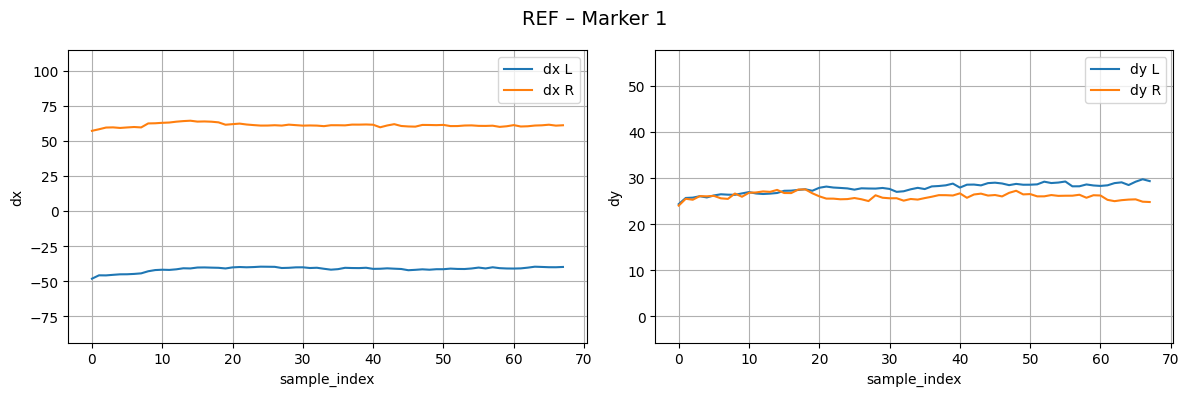

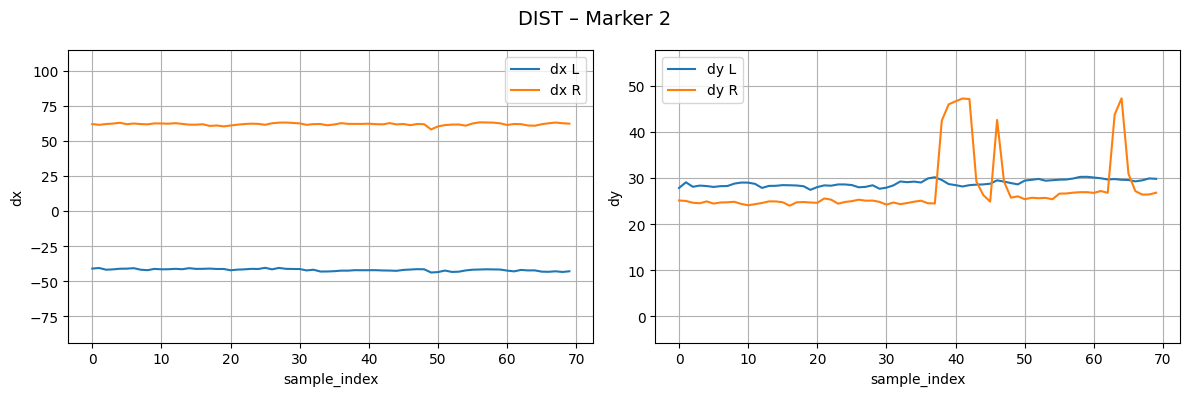

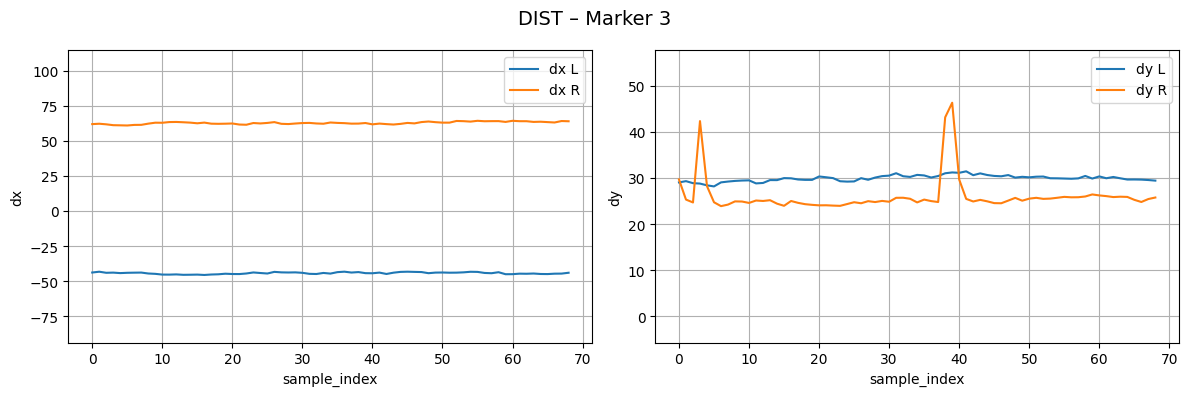

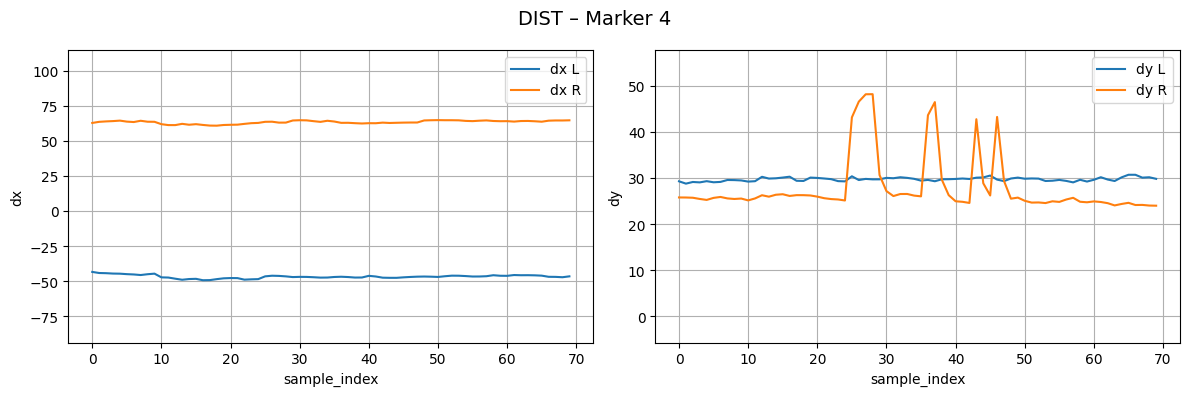

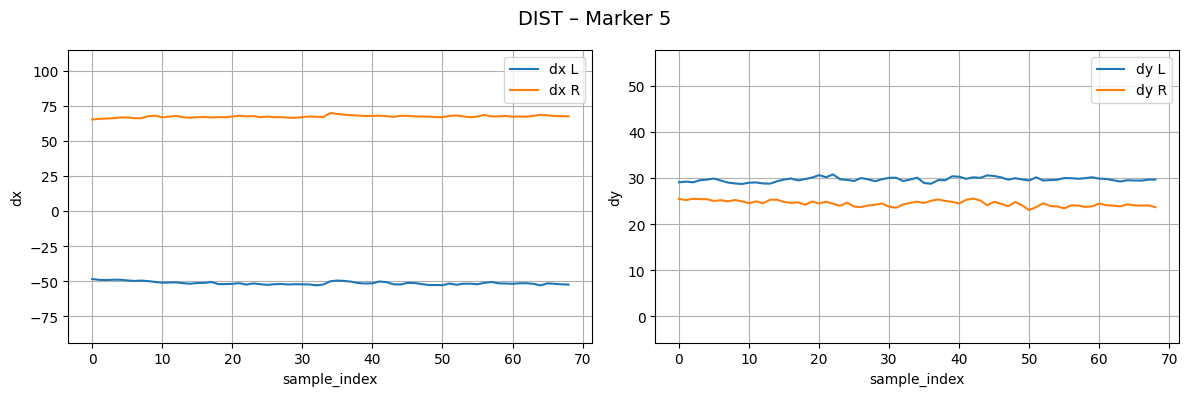

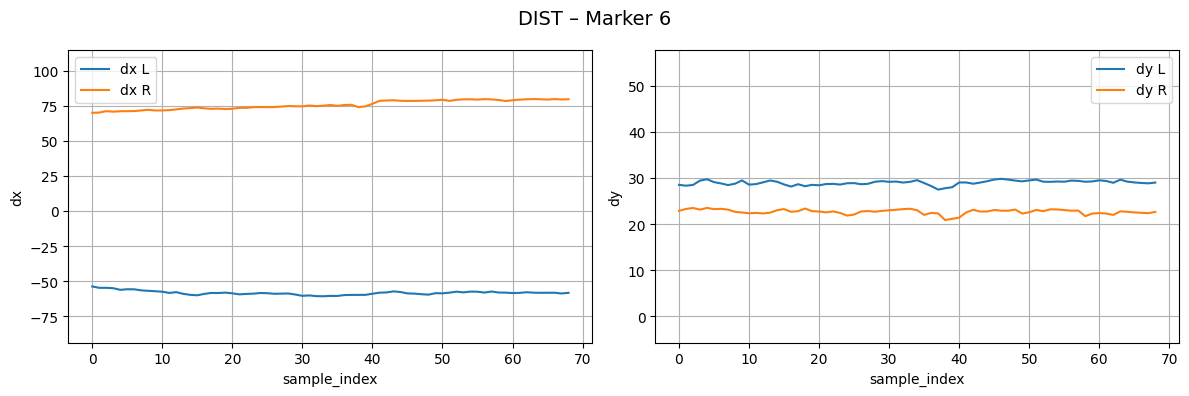

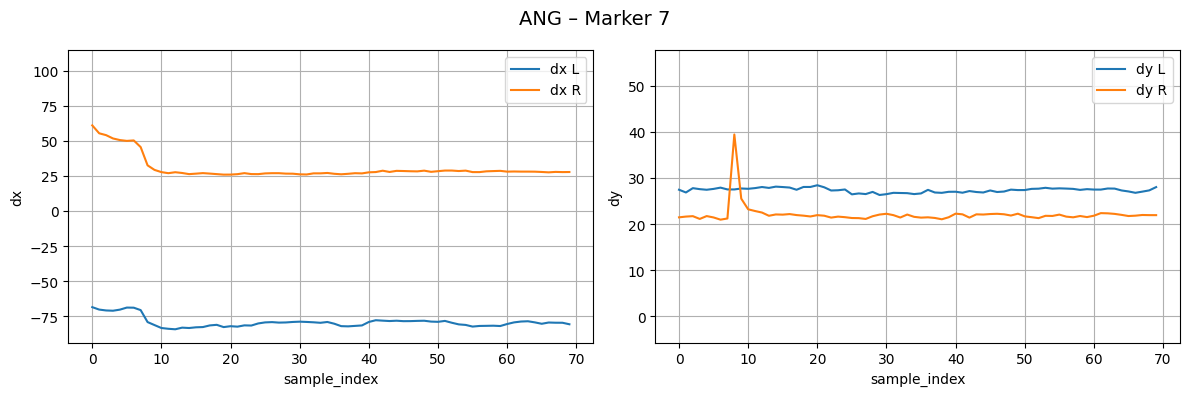

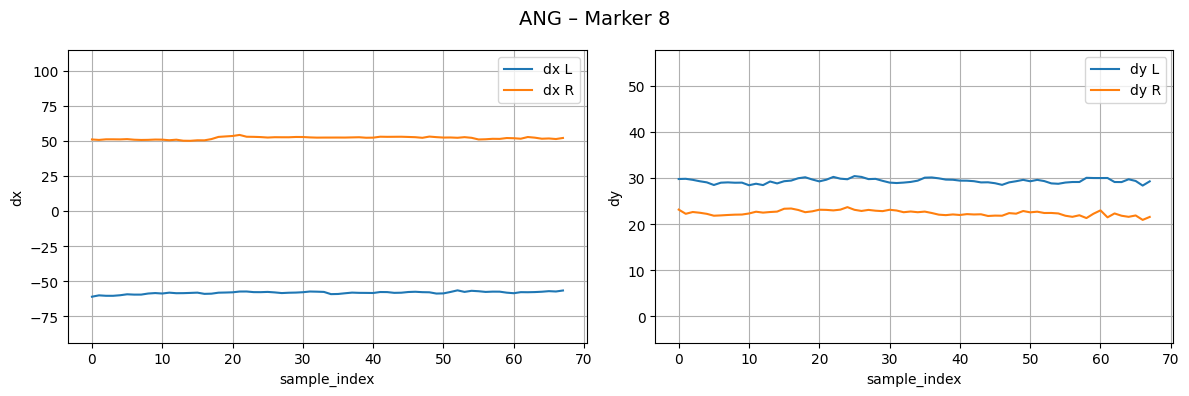

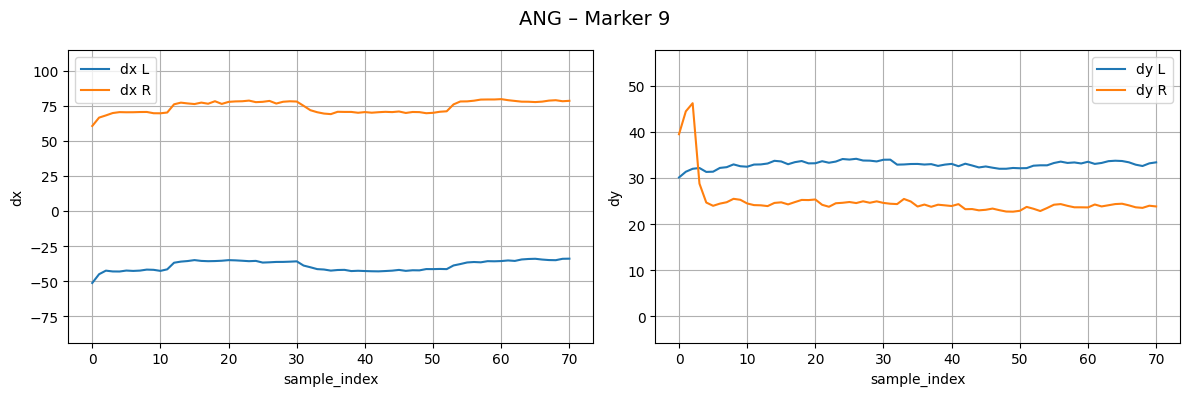

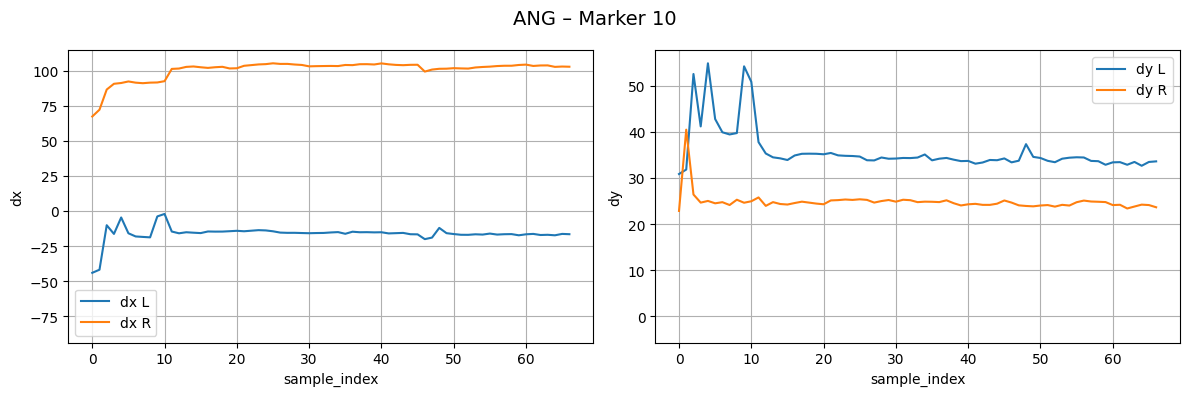

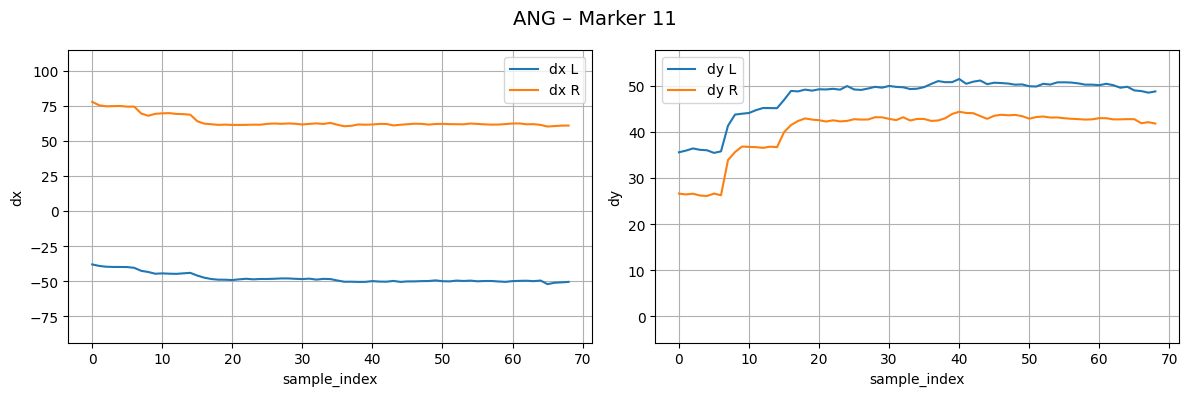

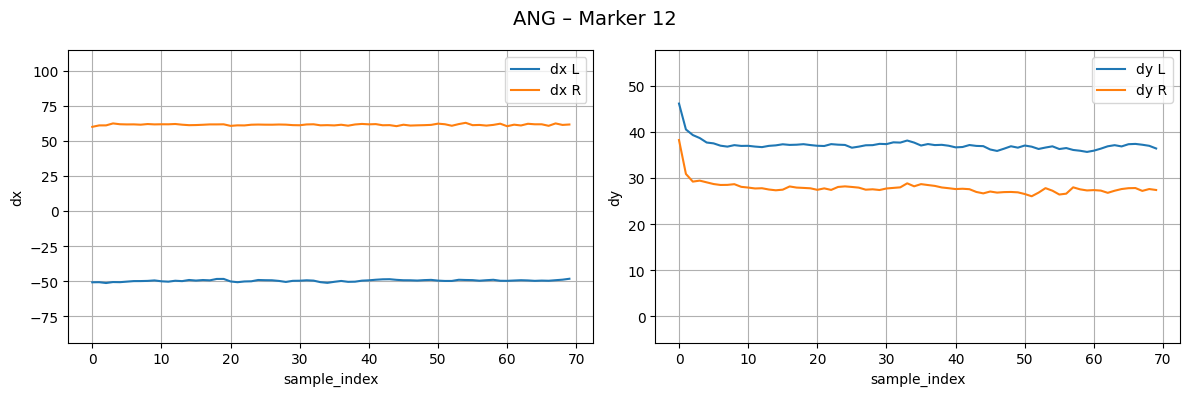

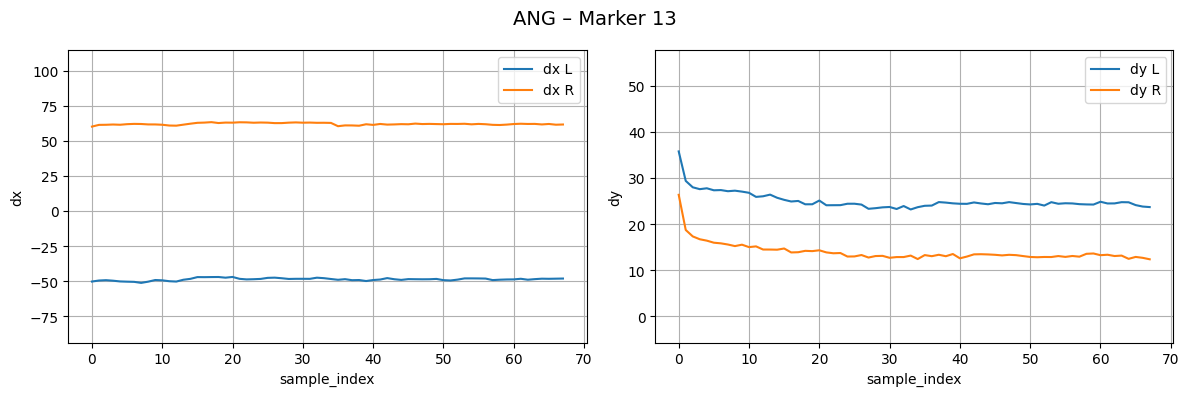

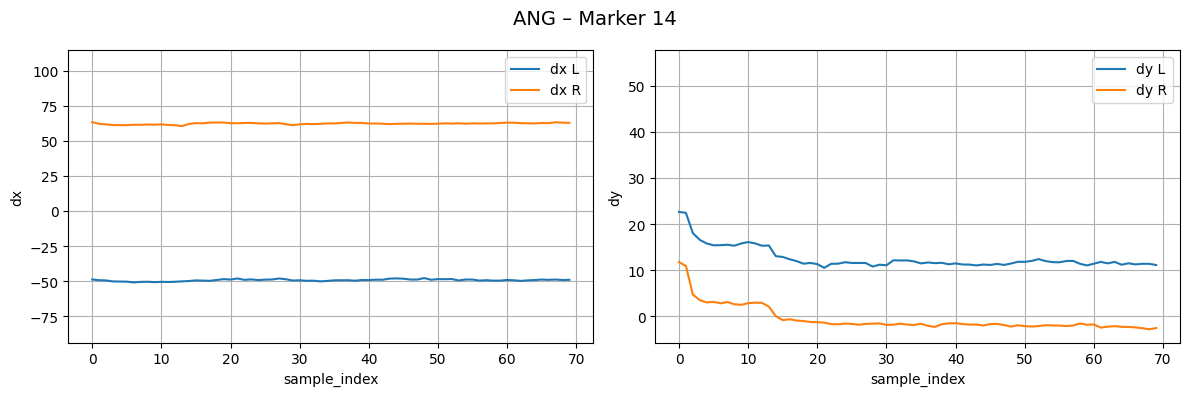

In [40]:
for g in groups:
    mtype = g["marker_type"]
    mid = g["marker_id"]

    plot_group_dx_dy(g)
